Experiment 1 with resnet18 transfer learning
============================================

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import gc
import torchnet as tnt
from utils import *
from classes import *
from tqdm import tqdm_notebook # for-loop progress bar in notebook

# plt setup and the gpu setup
plt.ion()
use_gpu = torch.cuda.is_available()

# load memory profiler
# %load_ext memory_profiler


print('main imports complete')

main imports complete


In [2]:
# ========================================
# Step 1. define data transform
#
# Including different forms of data augmentation
# One will include nearly all types (excluding random crops, etc. that may remove handwriting.)
# The other will include a selected set of augmentations
# Keeping 'train', 'val', and 'test' transforms just in case we want to include different functionalities
# ========================================

# Need the __name__ check to make multiprocessing work on Windows for some reason
# if __name__ == '__main__':
print("Set up data transforms.")
img_input_size = 56

selected_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        # RandomRotation does not seem to be working on Windows right now
        transforms.RandomRotation(45),

        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5),
        transforms.RandomGrayscale(p=0.1),

        transforms.Grayscale(), # not sure why the current input is not grayscale, do grayscale conversion
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    # should not do random transformation in val or test set
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
}

# Data augmentation and normalization for training
# Just normalization for validation
net1_data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(256),
        transforms.RandomResizedCrop(224), #apparently get an error if dont have this line
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),    
        transforms.Grayscale(),    
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

# data_transforms = selected_transforms
data_transforms = net1_data_transforms


Set up data transforms.


In [3]:
# ========================================
# Step 2. define and load data
#
# TODO: Suggest not using data loader to load the images. Because it is slow. Every epochs, you load the 
# image data again to the RAM and then from RAM to GPU RAM. That takes a lot of time. Since the images are 
# <1GB, you can preload the images into RAM first, that will make you training way faster. 

# Note: you only has about 200MB of images, it's small. It should not take much time to load!
# ========================================


print("Create dataset and dataloader")

# hyperparameter
# batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster
batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster

# data location
book_data_dir = '/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images'
set_types = ['train', 'val', 'test']

# Get the list of all books in the data set
books_in_data = set([b for b in os.listdir(book_data_dir)
                 if os.path.isdir(os.path.join(book_data_dir, b))])


print('Using default ImageFolder dataset.')
book_data_sets = {b : {t : datasets.ImageFolder(os.path.join(book_data_dir, b), 
                                                transform = data_transforms[t])#, transform=test_transform)
                      for t in set_types}
                 for b in books_in_data}

# create a dict of dataloaders, book_data_loaders['Albin']['train']
book_data_loaders = {b : {t : torch.utils.data.DataLoader(book_data_sets[b][t],
                                                          batch_size=batch_size,
                                                          shuffle=True, # make sure you shuffle the data
                                                          num_workers=4)
                          for t in set_types}
                     for b in books_in_data}



print('Counting images')
no_transform_datasets = {b : datasets.ImageFolder(os.path.join(book_data_dir, b)) for b in books_in_data}
image_counts = {book : {0 : 0, 1 : 0} for book in no_transform_datasets}
for book in no_transform_datasets:
    for im, target in no_transform_datasets[book]:
        image_counts[book][target] += 1
        
print(image_counts)

print("data loading complete")



Create dataset and dataloader
Using default ImageFolder dataset.
Counting images
{'Defoe': {0: 107, 1: 229}, 'Confucius': {0: 6, 1: 165}, 'Blackmore': {0: 36, 1: 292}, 'Montaigne': {0: 129, 1: 538}, 'Dryden': {0: 39, 1: 9}, 'Albin': {0: 143, 1: 31}, 'Voltaire': {0: 55, 1: 305}, 'Browne': {0: 160, 1: 200}, 'Allestree': {0: 66, 1: 212}, 'Ascham': {0: 20, 1: 76}}
data loading complete


In [4]:
# 
# ========================================
# Check your data to make sure it is correct
# ========================================

# for data in book_data_loaders['Defoe']['train']:
#     # get the inputs
#     inputs, labels = data

#     # plot to verify the input is correct
#     input1 = inputs[0].numpy()
#     print(input1.shape)
#     input1 = np.swapaxes(input1,0,2).squeeze()
#     print(input1.shape)
#     plt.imshow(input1,cmap='gray')

#     break

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#from https://github.com/pytorch/examples/blob/master/mnist/main.py
class JQNet1(nn.Module):
    def __init__(self):
        super(JQNet1, self).__init__()
        if use_gpu:
            self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cuda()
            self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cuda()
            self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cuda()
            self.conv2_drop = nn.Dropout2d(p = 0.2)
            self.conv3_drop = nn.Dropout2d(p = 0.1)

            #assumes a batch size of 50
            self.fc1 = nn.Linear(31360,64).cuda()
            self.fc2 = nn.Linear(64, 25).cuda()
            self.fc3 = nn.Linear(25,2).cuda()
        else:
            self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cpu()
            self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cpu()
            self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cpu()
            self.conv2_drop = nn.Dropout2d(p = 0.2)
            self.conv3_drop = nn.Dropout2d(p = 0.1)

            #assumes a batch size of 50
            self.fc1 = nn.Linear(31360,64).cpu()
            self.fc2 = nn.Linear(64, 25).cpu()
            self.fc3 = nn.Linear(25,2).cpu()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        #return x

In [6]:
# ========================================
# Step 3. define model structure
#
# TODO: Stick with MNIST for now because it is smaller network and faster to train. Note that you lose
# a lot of inofmration when yo udownsample the image to 28x28. THat's okay, you optimize other parts first, e.g.,
# data loading before you optimize your model.
# ========================================
from lib.playground.utee import selector
from lib.playground.mnist import model
import os

def create_model_architecture(model_type='mnist'):
    """
    params model_type: the type of model, for now, support mnist and resnet18    
    """
    if model_type == 'mnist':
        print('using pretrained mnist model')
        
        # load the model from the playground library
        model_annotation, ds_fetcher, is_imagenet = selector.select('mnist')
        
        # remove last layer
        removed = list(model_annotation.model.children())[:-1]
        
        # add a front layer to account for new input
        # IMPORTANT, we need to update the self.input_dims of the MLP class
        removed = [nn.Linear(img_input_size*img_input_size,28*28), nn.ReLU()] + removed
        
        # formulate the layers
        model_annotation.model=torch.nn.Sequential(*removed)
        
        # add the new fc layer
        model_annotation.model.fc = torch.nn.Linear(256,2).cuda()
        
        # update the self.input_dims of the network
        model_annotation.input_dims = img_input_size * img_input_size                

    elif model_type == 'resnet18':    
        print("Transferring resnet18 and retraining with annotations dataset.")    
        model_annotation = models.resnet18(pretrained=True)
        num_params = sum(1 for i in model_annotation.parameters())

        # There are 10 layers (model_ft.children()) in resnet18
        # Freezing the first half of resnet18, freezing all params for layers 1-5
        max_layer = 5
        curr_layer = 1
        last_layer = None
        for child in model_annotation.children():
            if curr_layer <= max_layer:
                for param in child.parameters():
                    param.requires_grad = False
                last_layer = child
                curr_layer = curr_layer + 1
            else:
                break

        # Replace the final fully connected layer to perform binary classification
        num_ftrs = model_annotation.fc.in_features
        model_annotation.fc = nn.Linear(num_ftrs, 2)
        
    elif model_type == 'jq_net1':
        print("Creating JQ's net1.")
        model_annotation = JQNet1()
        

    # return
    if use_gpu:
        return model_annotation.cuda()
    else:
        return model_annotation.cpu()


In [7]:
def safe_div(n1, n2):
    if n2 == 0:
        return 0
    return n1/n2

In [8]:
def compute_f1_score(tn, fp, fn, tp, class_type='pos'):
    if class_type == 'pos':
        prec   = safe_div(float(tp),(float(tp) + float(fp)))
        recall = safe_div(float(tp),(float(tp) + float(fn)))
    elif class_type == 'neg':
        prec   = safe_div(float(tn),(float(tn) + float(fn)))
        recall = safe_div(float(tn),(float(tn) + float(fp)))
        
    return safe_div(float(2) * (prec * recall), (prec + recall))

In [9]:
# ========================================
# Step 4. define the training process.
#
# TODO: The basic process of train and validation is defined. Please implement the overall average validation 
# confusion matrix, meaning for each validation (after running all epochs), get the confusion matrix for that book,
# repeat this for the rest of 10 books. THen get the overall performance. Also, implement the early-stop as you
# originally has in your code. :) I removed them here for clarity. You can add them back. 
# ========================================


def train(model, criterion, optimizer, data_loaders, num_epochs=25, early_stopping = None):    
    since = time.time()
    
    # number of samples for normalization of loss
    num_samples = {p : sum([len(data_loaders[p][b].dataset) for b in data_loaders[p]]) for p in ['train', 'val']}
    
    # accumulate metrics
    metric_names = [p+'-'+m for p in ['train', 'val'] for m in ['loss', 'tn', 'fp', 'fn', 'tp', 'f1_pos', 'f1_neg']]
    metrics_dict = {m : [] for m in metric_names}
    # stop the training, validation, and test loop
    for epoch in range(num_epochs):
        print()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # looping parameters
#         running_loss = 0.0
#         running_corrects = 0
#         confusion_matrix = tnt.meter.ConfusionMeter(2)
        
        # loop through train and val phase in each epoch
        for phase in ['train', 'val']:
            # check train or val
            if phase == 'train':                
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            # initialize variables needed for metrics per epoch
            running_loss = 0.0
            confusion_matrix = tnt.meter.ConfusionMeter(2)
            
            # Iterate over each book
            for book in data_loaders[phase]:
                for data in data_loaders[phase][book]:
                    
                    # get the inputs;  wrap them in Variable and make them into gpu or not
                    inputs, labels = data # input size: [5, 1, 28, 28] ; keep the dummy color channel:1
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        # forward
                        outputs = model(inputs)
                        _, preds = torch.max(outputs.data, 1)
                        loss = criterion(outputs, labels)

                        # back
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                        # Add to confusion matrix
                        confusion_matrix.add(outputs.data, labels.data)

                    # statistics
                    # Including inputs.size(0) scales the loss by the size of the batch
                    running_loss += (loss.item() * inputs.size(0))
            
            
            # compute evaluation
            epoch_loss = float(running_loss) / float(num_samples[phase])
            conf_tn    = confusion_matrix.conf[0][0]
            conf_fp    = confusion_matrix.conf[0][1]
            conf_fn    = confusion_matrix.conf[1][0]
            conf_tp    = confusion_matrix.conf[1][1]
            epoch_f1_p = compute_f1_score(conf_tn, conf_fp, conf_fn, conf_tp, class_type='pos')
            epoch_f1_n = compute_f1_score(conf_tn, conf_fp, conf_fn, conf_tp, class_type='neg')
            
            
            # accumulate metrics
            metrics_dict[phase+'-loss'].append(epoch_loss)
            metrics_dict[phase+'-tn'].append(conf_tn)
            metrics_dict[phase+'-fp'].append(conf_fp)
            metrics_dict[phase+'-fn'].append(conf_fn)
            metrics_dict[phase+'-tp'].append(conf_tp)
            metrics_dict[phase+'-f1_pos'].append(epoch_f1_p)
            metrics_dict[phase+'-f1_neg'].append(epoch_f1_n)
            
            # report evaluation
            print('Phase:%s' %phase)
            print('average loss:', epoch_loss)
            print('f1_pos:', epoch_f1_p)
            print('f1_neg:', epoch_f1_n)
            print()

    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    # return both the trained model and the metrics
    return model, metrics_dict

In [10]:
def plot_values(train_values, val_values, title, ylabel='Loss'):
    plt.plot(train_values,label = "train")
    plt.plot(val_values,label = "validation")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()


    print("Average Training Score: " + str(np.mean(train_values)))
    print("Average Validation Score: " + str(np.mean(val_values)))

In [11]:
def write_metrics_to_csv(raw_metrics, metric_names, dirname, filename):
    import csv
    import os
    
    if not os.path.exists(dirname):
        os.makedirs(dirname)
        
    fileloc = os.path.join(dirname, filename)
    with open(fileloc, 'w') as outfile:
        filewriter = csv.writer(outfile, delimiter=',')
        filewriter.writerow(metric_names)
        for epoch in range(len(raw_metrics[metric_names[0]])):
            newrow = [raw_metrics[metric][epoch] for metric in metric_names]
            filewriter.writerow(newrow)
            
    print("Wrote metrics to '" + str(fileloc) + "'")
    return

use_gpu is True
validating on book: 'Defoe'
Creating JQ's net1.
train counts {0: 654, 1: 1828}

Epoch 0/99
----------
Phase:train
average loss: 0.6889187339318077
f1_pos: 0.8235860409145607
f1_neg: 0.09394313967861558

Phase:val
average loss: 0.6952127750430789
f1_pos: 0.8106194690265487
f1_neg: 0


Epoch 1/99
----------
Phase:train
average loss: 0.700249675514235
f1_pos: 0.8220623501199041
f1_neg: 0.06549118387909321

Phase:val
average loss: 0.6974524447605723
f1_pos: 0.8106194690265487
f1_neg: 0


Epoch 2/99
----------
Phase:train
average loss: 0.6838816633923798
f1_pos: 0.8371327849588719
f1_neg: 0.022566995768688293

Phase:val
average loss: 0.6963122895076161
f1_pos: 0.8106194690265487
f1_neg: 0


Epoch 3/99
----------
Phase:train
average loss: 0.6909291556436722
f1_pos: 0.8439981317141522
f1_neg: 0.020527859237536656

Phase:val
average loss: 0.6981748321226665
f1_pos: 0.8106194690265487
f1_neg: 0


Epoch 4/99
----------
Phase:train
average loss: 0.6909599446366623
f1_pos: 0.847047

Phase:train
average loss: 0.6388278012430351
f1_pos: 0.8629737609329446
f1_neg: 0.33490566037735847

Phase:val
average loss: 0.7170231558737301
f1_pos: 0.8142857142857143
f1_neg: 0.07142857142857142


Epoch 40/99
----------
Phase:train
average loss: 0.63544924126144
f1_pos: 0.8664889750424036
f1_neg: 0.34169653524492233

Phase:val
average loss: 0.7174384253365653
f1_pos: 0.8142857142857143
f1_neg: 0.07142857142857142


Epoch 41/99
----------
Phase:train
average loss: 0.6316718258125757
f1_pos: 0.8663101604278075
f1_neg: 0.3529411764705882

Phase:val
average loss: 0.7179709978046871
f1_pos: 0.8142857142857143
f1_neg: 0.07142857142857142


Epoch 42/99
----------
Phase:train
average loss: 0.6298417564028218
f1_pos: 0.8619759745035548
f1_neg: 0.3638418079096046

Phase:val
average loss: 0.7181826233863831
f1_pos: 0.8142857142857143
f1_neg: 0.07142857142857142


Epoch 43/99
----------
Phase:train
average loss: 0.6329500619247015
f1_pos: 0.8644973288003884
f1_neg: 0.3404255319148936

Phase:va

Phase:train
average loss: 0.6238773159208459
f1_pos: 0.8651931017731358
f1_neg: 0.3447461629279811

Phase:val
average loss: 0.7321446587642034
f1_pos: 0.8142857142857143
f1_neg: 0.07142857142857142


Epoch 77/99
----------
Phase:train
average loss: 0.6248587826199343
f1_pos: 0.8687211841785973
f1_neg: 0.35824436536180304

Phase:val
average loss: 0.7311347825896173
f1_pos: 0.815742397137746
f1_neg: 0.08849557522123892


Epoch 78/99
----------
Phase:train
average loss: 0.6173318152366195
f1_pos: 0.8573584905660376
f1_neg: 0.42669362992922144

Phase:val
average loss: 0.727301873976276
f1_pos: 0.8150807899461399
f1_neg: 0.10434782608695652


Epoch 79/99
----------
Phase:train
average loss: 0.6329001038666218
f1_pos: 0.8624299975651327
f1_neg: 0.34072345390898484

Phase:val
average loss: 0.7318915852478572
f1_pos: 0.815742397137746
f1_neg: 0.08849557522123892


Epoch 80/99
----------
Phase:train
average loss: 0.6239206221534013
f1_pos: 0.8591897233201581
f1_neg: 0.3777292576419214

Phase:va

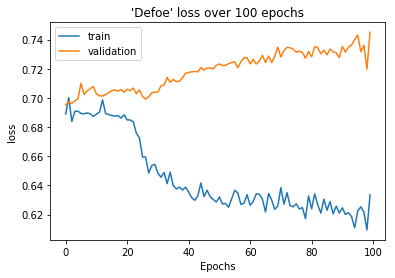

Average Training Score: 0.6456557436345639
Average Validation Score: 0.7189343797734806


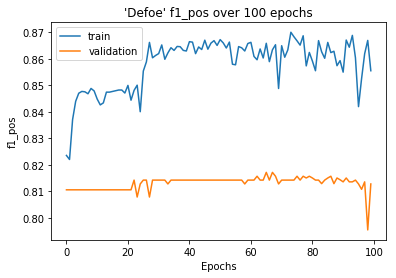

Average Training Score: 0.8580243851343634
Average Validation Score: 0.8131751578768056


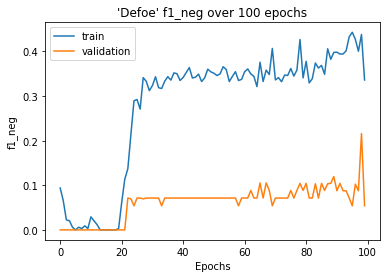

Average Training Score: 0.2780323404946063
Average Validation Score: 0.06151088390288363
Wrote metrics to 'raw_logs/Defoe.csv'

validating on book: 'Confucius'
Creating JQ's net1.
train counts {0: 755, 1: 1892}

Epoch 0/99
----------
Phase:train
average loss: 0.7060042373135174
f1_pos: 0.7451176765147721
f1_neg: 0.21692307692307694

Phase:val
average loss: 0.697388129624707
f1_pos: 0
f1_neg: 0.04571428571428571


Epoch 1/99
----------
Phase:train
average loss: 0.6964479653529955
f1_pos: 0.802939825447864
f1_neg: 0.08723404255319149

Phase:val
average loss: 0.6657874660882336
f1_pos: 0.9821428571428572
f1_neg: 0


Epoch 2/99
----------
Phase:train
average loss: 0.6926262976990856
f1_pos: 0.8211327512872174
f1_neg: 0.03385731559854897

Phase:val
average loss: 0.6570344853122332
f1_pos: 0.9821428571428572
f1_neg: 0


Epoch 3/99
----------
Phase:train
average loss: 0.6916069796412316
f1_pos: 0.8322295805739515
f1_neg: 0.005235602094240838

Phase:val
average loss: 0.6502424332133511
f1_pos:

Phase:val
average loss: 0.6164658515774019
f1_pos: 0.9820359281437127
f1_neg: 0.25


Epoch 40/99
----------
Phase:train
average loss: 0.6797426233077256
f1_pos: 0.8337457817772778
f1_neg: 0.12956419316843343

Phase:val
average loss: 0.618663489818573
f1_pos: 0.984984984984985
f1_neg: 0.4444444444444444


Epoch 41/99
----------
Phase:train
average loss: 0.6769087328791934
f1_pos: 0.8401888064733648
f1_neg: 0.15857988165680473

Phase:val
average loss: 0.617849157916175
f1_pos: 0.984984984984985
f1_neg: 0.4444444444444444


Epoch 42/99
----------
Phase:train
average loss: 0.6835106043803003
f1_pos: 0.8345323741007193
f1_neg: 0.13002364066193853

Phase:val
average loss: 0.6182801740908483
f1_pos: 0.9820359281437127
f1_neg: 0.25


Epoch 43/99
----------
Phase:train
average loss: 0.6766446416315872
f1_pos: 0.8390572390572392
f1_neg: 0.14541120381406436

Phase:val
average loss: 0.6166956463055304
f1_pos: 0.984984984984985
f1_neg: 0.4444444444444444


Epoch 44/99
----------
Phase:train
average

Phase:val
average loss: 0.5930434747746116
f1_pos: 0.9788519637462236
f1_neg: 0.3636363636363636


Epoch 78/99
----------
Phase:train
average loss: 0.6448136152390673
f1_pos: 0.8502573701450631
f1_neg: 0.37254901960784315

Phase:val
average loss: 0.5952086629923324
f1_pos: 0.9757575757575757
f1_neg: 0.3333333333333333


Epoch 79/99
----------
Phase:train
average loss: 0.6430038696061362
f1_pos: 0.8423797108319506
f1_neg: 0.38139534883720927

Phase:val
average loss: 0.5932167674365797
f1_pos: 0.9788519637462236
f1_neg: 0.3636363636363636


Epoch 80/99
----------
Phase:train
average loss: 0.6388134716320002
f1_pos: 0.8504781898763704
f1_neg: 0.3634558093346574

Phase:val
average loss: 0.5882977745686359
f1_pos: 0.9788519637462236
f1_neg: 0.3636363636363636


Epoch 81/99
----------
Phase:train
average loss: 0.6349936700290584
f1_pos: 0.8546049555867228
f1_neg: 0.38779527559055116

Phase:val
average loss: 0.5824544210182993
f1_pos: 0.9788519637462236
f1_neg: 0.3636363636363636


Epoch 82/9

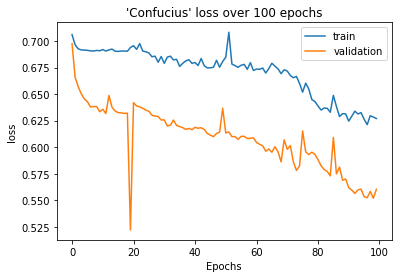

Average Training Score: 0.6709614814082135
Average Validation Score: 0.6085777790347735


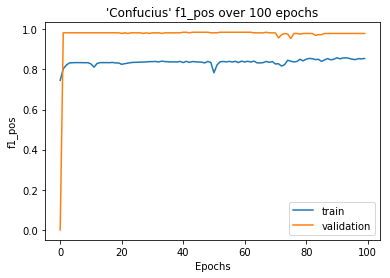

Average Training Score: 0.8364785592392792
Average Validation Score: 0.970947208902291


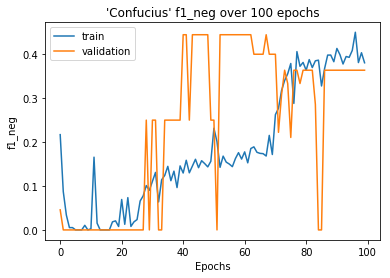

Average Training Score: 0.18403594668681333
Average Validation Score: 0.24063788609051767
Wrote metrics to 'raw_logs/Confucius.csv'

validating on book: 'Blackmore'
Creating JQ's net1.
train counts {0: 725, 1: 1765}

Epoch 0/99
----------
Phase:train
average loss: 0.7012950233666294
f1_pos: 0.6334981458590854
f1_neg: 0.319954128440367

Phase:val
average loss: 0.6970703332889371
f1_pos: 0
f1_neg: 0.1978021978021978


Epoch 1/99
----------
Phase:train
average loss: 0.6965443457944326
f1_pos: 0.6585220500595946
f1_neg: 0.2943349753694582

Phase:val
average loss: 0.6886111777730104
f1_pos: 0.9419354838709678
f1_neg: 0


Epoch 2/99
----------
Phase:train
average loss: 0.6990948928886628
f1_pos: 0.7503966155473295
f1_neg: 0.21202003338898165

Phase:val
average loss: 0.6867595794724255
f1_pos: 0.9419354838709678
f1_neg: 0


Epoch 3/99
----------
Phase:train
average loss: 0.6930831477823985
f1_pos: 0.7621761658031089
f1_neg: 0.18035714285714283

Phase:val
average loss: 0.6804075818963167
f1_po

Phase:train
average loss: 0.6355020445513438
f1_pos: 0.8281733746130031
f1_neg: 0.39673913043478265

Phase:val
average loss: 0.6423161502291517
f1_pos: 0.7945205479452054
f1_neg: 0.27586206896551724


Epoch 38/99
----------
Phase:train
average loss: 0.6366337989228796
f1_pos: 0.8368394048229861
f1_neg: 0.41219963031423296

Phase:val
average loss: 0.6709886345921493
f1_pos: 0.6622807017543859
f1_neg: 0.23000000000000004


Epoch 39/99
----------
Phase:train
average loss: 0.6369720521940285
f1_pos: 0.8251380489087563
f1_neg: 0.43500424808836025

Phase:val
average loss: 0.6941146508949559
f1_pos: 0.3957219251336898
f1_neg: 0.19858156028368795


Epoch 40/99
----------
Phase:train
average loss: 0.6403641120497002
f1_pos: 0.8194480946123522
f1_neg: 0.4153191489361702

Phase:val
average loss: 0.6853487186315583
f1_pos: 0.3571428571428571
f1_neg: 0.19863013698630136


Epoch 41/99
----------
Phase:train
average loss: 0.6282036703753184
f1_pos: 0.8249149437320074
f1_neg: 0.4227782571182053

Phase

Phase:train
average loss: 0.6234262963255726
f1_pos: 0.8325058792788085
f1_neg: 0.44405897658282734

Phase:val
average loss: 0.6408084605525179
f1_pos: 0.864963503649635
f1_neg: 0.3148148148148148


Epoch 75/99
----------
Phase:train
average loss: 0.6213621054906922
f1_pos: 0.836591086786552
f1_neg: 0.4514435695538058

Phase:val
average loss: 0.6750176930572929
f1_pos: 0.5801886792452831
f1_neg: 0.23275862068965517


Epoch 76/99
----------
Phase:train
average loss: 0.6242373242196309
f1_pos: 0.8369310793237972
f1_neg: 0.4475770925110132

Phase:val
average loss: 0.7060465732725655
f1_pos: 0.33053221288515405
f1_neg: 0.20066889632107024


Epoch 77/99
----------
Phase:train
average loss: 0.6299502625762219
f1_pos: 0.8351421188630491
f1_neg: 0.42522522522522516

Phase:val
average loss: 0.6780706862124001
f1_pos: 0.5245098039215688
f1_neg: 0.21774193548387094


Epoch 78/99
----------
Phase:train
average loss: 0.6181018300444246
f1_pos: 0.8251336898395721
f1_neg: 0.4725806451612903

Phase:va

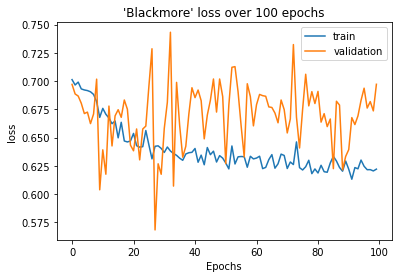

Average Training Score: 0.6396284206911743
Average Validation Score: 0.6699323913491352


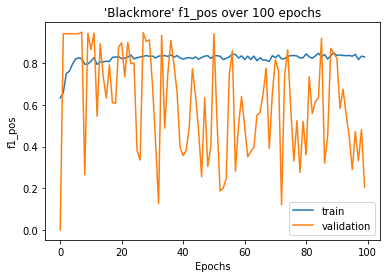

Average Training Score: 0.8225055966687214
Average Validation Score: 0.6091369296867659


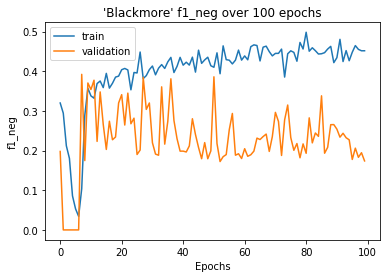

Average Training Score: 0.402043468164856
Average Validation Score: 0.2288584635470734
Wrote metrics to 'raw_logs/Blackmore.csv'

validating on book: 'Montaigne'
Creating JQ's net1.
train counts {0: 632, 1: 1519}

Epoch 0/99
----------
Phase:train
average loss: 0.7806910211848193
f1_pos: 0.3851851851851852
f1_neg: 0.3800186741363212

Phase:val
average loss: 0.7310864351678645
f1_pos: 0
f1_neg: 0.3241206030150754


Epoch 1/99
----------
Phase:train
average loss: 0.745530917055936
f1_pos: 0.3598286530223703
f1_neg: 0.38891412994093594

Phase:val
average loss: 0.7272761796546662
f1_pos: 0
f1_neg: 0.3241206030150754


Epoch 2/99
----------
Phase:train
average loss: 0.7207494275839259
f1_pos: 0.33980582524271846
f1_neg: 0.39339875111507583

Phase:val
average loss: 0.7250153324057137
f1_pos: 0
f1_neg: 0.3241206030150754


Epoch 3/99
----------
Phase:train
average loss: 0.7093753134688905
f1_pos: 0.17983963344788084
f1_neg: 0.43974960876369323

Phase:val
average loss: 0.7155043430056708
f1_po

Phase:val
average loss: 0.6583404857358117
f1_pos: 0.897822445561139
f1_neg: 0.12857142857142856


Epoch 37/99
----------
Phase:train
average loss: 0.6753282423409569
f1_pos: 0.8325892857142857
f1_neg: 0.16434540389972147

Phase:val
average loss: 0.6539341487448433
f1_pos: 0.8985750209555742
f1_neg: 0.14184397163120568


Epoch 38/99
----------
Phase:train
average loss: 0.6706789324362297
f1_pos: 0.8333333333333334
f1_neg: 0.16246498599439774

Phase:val
average loss: 0.6626960293821309
f1_pos: 0.8985750209555742
f1_neg: 0.14184397163120568


Epoch 39/99
----------
Phase:train
average loss: 0.6853851804839683
f1_pos: 0.814921920185078
f1_neg: 0.24170616113744078

Phase:val
average loss: 0.6604475158265327
f1_pos: 0.898744769874477
f1_neg: 0.12949640287769784


Epoch 40/99
----------
Phase:train
average loss: 0.6747893786386022
f1_pos: 0.8204693242861183
f1_neg: 0.16993464052287582

Phase:val
average loss: 0.6619106047693221
f1_pos: 0.897822445561139
f1_neg: 0.12857142857142856


Epoch 41

Phase:val
average loss: 0.636144273016585
f1_pos: 0.8923341946597761
f1_neg: 0.27745664739884396


Epoch 74/99
----------
Phase:train
average loss: 0.6238221067264987
f1_pos: 0.8464925154094511
f1_neg: 0.41564245810055866

Phase:val
average loss: 0.6549470414822248
f1_pos: 0.8239700374531835
f1_neg: 0.2932330827067669


Epoch 75/99
----------
Phase:train
average loss: 0.6183915418810425
f1_pos: 0.8466548253404382
f1_neg: 0.43939393939393945

Phase:val
average loss: 0.6548395726991736
f1_pos: 0.8149568552253116
f1_neg: 0.3367697594501718


Epoch 76/99
----------
Phase:train
average loss: 0.6256741928477888
f1_pos: 0.8410991636798087
f1_neg: 0.44234800838574423

Phase:val
average loss: 0.6943390494522483
f1_pos: 0.575609756097561
f1_neg: 0.3229571984435798


Epoch 77/99
----------
Phase:train
average loss: 0.6081696045171489
f1_pos: 0.8415071770334926
f1_neg: 0.4467640918580375

Phase:val
average loss: 0.6608455865636937
f1_pos: 0.7776669990029911
f1_neg: 0.32628398791540786


Epoch 78/9

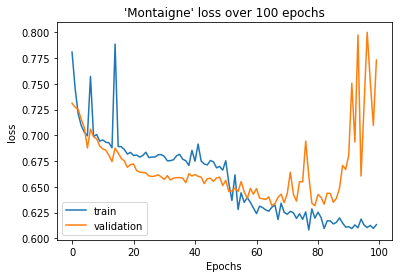

Average Training Score: 0.6573482655346921
Average Validation Score: 0.6685488231375121


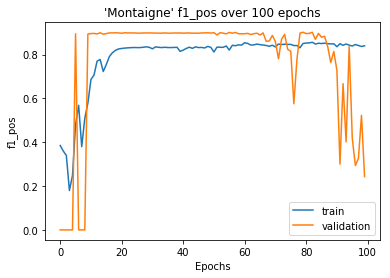

Average Training Score: 0.787977060942438
Average Validation Score: 0.7713635951847151


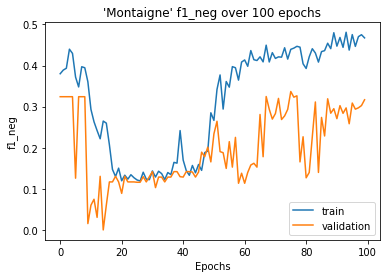

Average Training Score: 0.3156916544244164
Average Validation Score: 0.19633570058679795
Wrote metrics to 'raw_logs/Montaigne.csv'

validating on book: 'Dryden'
Creating JQ's net1.
train counts {0: 722, 1: 2048}

Epoch 0/99
----------
Phase:train
average loss: 0.723248840755504
f1_pos: 0.5728409421343414
f1_neg: 0.3008091385054736

Phase:val
average loss: 0.6774746775627136
f1_pos: 0
f1_neg: 0.896551724137931


Epoch 1/99
----------
Phase:train
average loss: 0.6930004277599418
f1_pos: 0.6217500698909701
f1_neg: 0.31074885379521144

Phase:val
average loss: 0.6880342364311218
f1_pos: 0
f1_neg: 0.896551724137931


Epoch 2/99
----------
Phase:train
average loss: 0.7055253442013737
f1_pos: 0.7037692891474829
f1_neg: 0.26212980466288593

Phase:val
average loss: 0.6993886232376099
f1_pos: 0.3157894736842105
f1_neg: 0


Epoch 3/99
----------
Phase:train
average loss: 0.6922409619450138
f1_pos: 0.8012408597385331
f1_neg: 0.12658227848101267

Phase:val
average loss: 0.7190154790878296
f1_pos: 0.

Phase:val
average loss: 0.7712920308113098
f1_pos: 0.3157894736842105
f1_neg: 0


Epoch 41/99
----------
Phase:train
average loss: 0.6895954223961607
f1_pos: 0.8501452885014529
f1_neg: 0

Phase:val
average loss: 0.7721861004829407
f1_pos: 0.3157894736842105
f1_neg: 0


Epoch 42/99
----------
Phase:train
average loss: 0.6893027686255073
f1_pos: 0.8501452885014529
f1_neg: 0

Phase:val
average loss: 0.7710331678390503
f1_pos: 0.3157894736842105
f1_neg: 0


Epoch 43/99
----------
Phase:train
average loss: 0.6897225620944577
f1_pos: 0.8501452885014529
f1_neg: 0

Phase:val
average loss: 0.7705783247947693
f1_pos: 0.3157894736842105
f1_neg: 0


Epoch 44/99
----------
Phase:train
average loss: 0.6894132596491046
f1_pos: 0.8501452885014529
f1_neg: 0

Phase:val
average loss: 0.7712965607643127
f1_pos: 0.3157894736842105
f1_neg: 0


Epoch 45/99
----------
Phase:train
average loss: 0.6894117414736145
f1_pos: 0.8501452885014529
f1_neg: 0

Phase:val
average loss: 0.7711657285690308
f1_pos: 0.3157894

Phase:train
average loss: 0.6894690515117095
f1_pos: 0.8501452885014529
f1_neg: 0

Phase:val
average loss: 0.7773468494415283
f1_pos: 0.3157894736842105
f1_neg: 0


Epoch 85/99
----------
Phase:train
average loss: 0.6890922346915579
f1_pos: 0.8501452885014529
f1_neg: 0

Phase:val
average loss: 0.777648389339447
f1_pos: 0.3157894736842105
f1_neg: 0


Epoch 86/99
----------
Phase:train
average loss: 0.6946903797263273
f1_pos: 0.8386416367854883
f1_neg: 0.0425531914893617

Phase:val
average loss: 0.7776913642883301
f1_pos: 0.3157894736842105
f1_neg: 0


Epoch 87/99
----------
Phase:train
average loss: 0.6887929663331069
f1_pos: 0.8504362276692979
f1_neg: 0.008264462809917356

Phase:val
average loss: 0.7772296667098999
f1_pos: 0.3157894736842105
f1_neg: 0


Epoch 88/99
----------
Phase:train
average loss: 0.6895258293255141
f1_pos: 0.8419945297706711
f1_neg: 0.0457433290978399

Phase:val
average loss: 0.7771324515342712
f1_pos: 0.3157894736842105
f1_neg: 0


Epoch 89/99
----------
Phase:tr

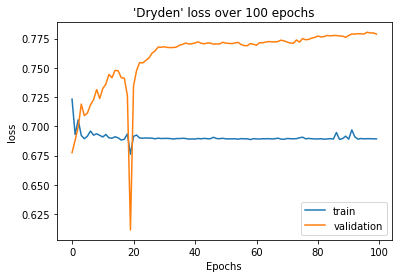

Average Training Score: 0.6903822732410707
Average Validation Score: 0.7606322938203811


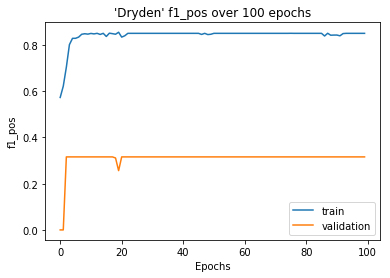

Average Training Score: 0.8413736300075336
Average Validation Score: 0.3088331084120558


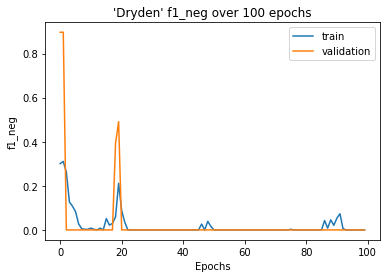

Average Training Score: 0.02076555286393048
Average Validation Score: 0.02676488381196399
Wrote metrics to 'raw_logs/Dryden.csv'

validating on book: 'Albin'
Creating JQ's net1.
train counts {0: 618, 1: 2026}

Epoch 0/99
----------
Phase:train
average loss: 0.710618386831298
f1_pos: 0.6965498505840804
f1_neg: 0.3049159925326696

Phase:val
average loss: 0.6903377641206501
f1_pos: 0.20833333333333334
f1_neg: 0.6984126984126984


Epoch 1/99
----------
Phase:train
average loss: 0.7146943614856198
f1_pos: 0.7172634954569748
f1_neg: 0.31565329883570503

Phase:val
average loss: 0.6790880170361749
f1_pos: 0
f1_neg: 0.9022082018927445


Epoch 2/99
----------
Phase:train
average loss: 0.6985221076164952
f1_pos: 0.6072684642438453
f1_neg: 0.28571428571428575

Phase:val
average loss: 0.6947878688231282
f1_pos: 0.2937853107344633
f1_neg: 0.26900584795321636


Epoch 3/99
----------
Phase:train
average loss: 0.6965711605756257
f1_pos: 0.7818831942789035
f1_neg: 0.16285452881976215

Phase:val
average 

Phase:train
average loss: 0.6457084059692728
f1_pos: 0.8748882931188561
f1_neg: 0.3103448275862069

Phase:val
average loss: 0.6908403258214052
f1_pos: 0.29239766081871343
f1_neg: 0.3163841807909604


Epoch 38/99
----------
Phase:train
average loss: 0.6383452063564453
f1_pos: 0.869742198100407
f1_neg: 0.33487297921478054

Phase:val
average loss: 0.703942182420314
f1_pos: 0.2906976744186046
f1_neg: 0.30681818181818177


Epoch 39/99
----------
Phase:train
average loss: 0.6397660641329371
f1_pos: 0.8752793920429146
f1_neg: 0.3144963144963145

Phase:val
average loss: 0.7104084567091931
f1_pos: 0.2988505747126437
f1_neg: 0.2988505747126437


Epoch 40/99
----------
Phase:train
average loss: 0.6461341506188648
f1_pos: 0.8727843841148755
f1_neg: 0.31768953068592054

Phase:val
average loss: 0.7078138699476746
f1_pos: 0.29239766081871343
f1_neg: 0.3163841807909604


Epoch 41/99
----------
Phase:train
average loss: 0.6461434572619498
f1_pos: 0.8674644389252653
f1_neg: 0.3166472642607683

Phase:val

Phase:val
average loss: 0.7024610042572021
f1_pos: 0.3125
f1_neg: 0.4148936170212766


Epoch 75/99
----------
Phase:train
average loss: 0.6374145695283084
f1_pos: 0.8550289017341041
f1_neg: 0.3489096573208723

Phase:val
average loss: 0.71865864252222
f1_pos: 0.2976190476190476
f1_neg: 0.34444444444444444


Epoch 76/99
----------
Phase:train
average loss: 0.6348486154505056
f1_pos: 0.8606782768102658
f1_neg: 0.341991341991342

Phase:val
average loss: 0.6821890123959246
f1_pos: 0.31168831168831174
f1_neg: 0.4536082474226804


Epoch 77/99
----------
Phase:train
average loss: 0.6380386253799144
f1_pos: 0.835425053279659
f1_neg: 0.3474178403755869

Phase:val
average loss: 0.7033837800738455
f1_pos: 0.2857142857142857
f1_neg: 0.33333333333333337


Epoch 78/99
----------
Phase:train
average loss: 0.6319850127969314
f1_pos: 0.8610919143054596
f1_neg: 0.36325237592397047

Phase:val
average loss: 0.7119803188861101
f1_pos: 0.289308176100629
f1_neg: 0.40211640211640215


Epoch 79/99
----------
Ph

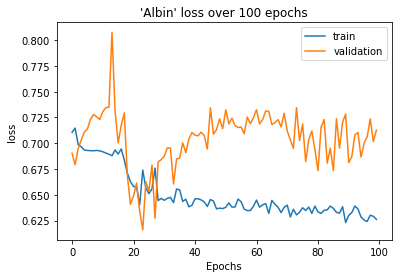

Average Training Score: 0.6503877377173047
Average Validation Score: 0.7042095818396272


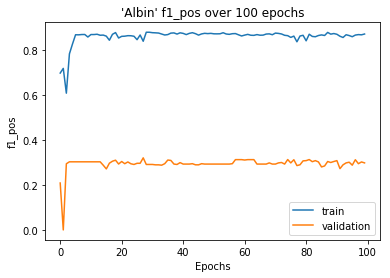

Average Training Score: 0.8589691796395356
Average Validation Score: 0.2938060388947459


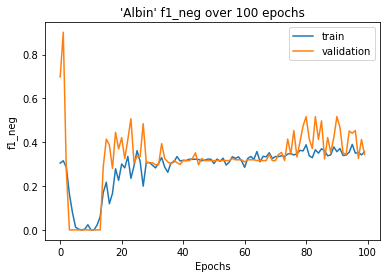

Average Training Score: 0.2865783135040027
Average Validation Score: 0.3264451385979624
Wrote metrics to 'raw_logs/Albin.csv'

validating on book: 'Voltaire'
Creating JQ's net1.
train counts {0: 706, 1: 1752}

Epoch 0/99
----------
Phase:train
average loss: 0.7059358627792294
f1_pos: 0.7937860185417189
f1_neg: 0.11027027027027027

Phase:val
average loss: 0.6652402745352851
f1_pos: 0.9172932330827067
f1_neg: 0


Epoch 1/99
----------
Phase:train
average loss: 0.6953926726848347
f1_pos: 0.8323040380047506
f1_neg: 0

Phase:val
average loss: 0.6649380111032062
f1_pos: 0.9172932330827067
f1_neg: 0


Epoch 2/99
----------
Phase:train
average loss: 0.6946243033164686
f1_pos: 0.8310328415040458
f1_neg: 0.0056022408963585435

Phase:val
average loss: 0.6659476425912645
f1_pos: 0.9172932330827067
f1_neg: 0


Epoch 3/99
----------
Phase:train
average loss: 0.6948624333053027
f1_pos: 0.82392667631452
f1_neg: 0.05194805194805195

Phase:val
average loss: 0.6634036236339145
f1_pos: 0.9172932330827067


Phase:train
average loss: 0.6890009040023565
f1_pos: 0.8327368169887854
f1_neg: 0.03310344827586208

Phase:val
average loss: 0.6601671261919869
f1_pos: 0.9172932330827067
f1_neg: 0


Epoch 40/99
----------
Phase:train
average loss: 0.6897998713593448
f1_pos: 0.8315839694656488
f1_neg: 0.024861878453038676

Phase:val
average loss: 0.6610538909832636
f1_pos: 0.9172932330827067
f1_neg: 0


Epoch 41/99
----------
Phase:train
average loss: 0.6949394306727208
f1_pos: 0.805769709027605
f1_neg: 0.12737430167597766

Phase:val
average loss: 0.6598108543290032
f1_pos: 0.9172932330827067
f1_neg: 0


Epoch 42/99
----------
Phase:train
average loss: 0.6928220358294525
f1_pos: 0.8238677210639828
f1_neg: 0.010767160161507403

Phase:val
average loss: 0.6597810205486085
f1_pos: 0.9172932330827067
f1_neg: 0


Epoch 43/99
----------
Phase:train
average loss: 0.690563566103711
f1_pos: 0.8323040380047506
f1_neg: 0

Phase:val
average loss: 0.6585660179456075
f1_pos: 0.9172932330827067
f1_neg: 0


Epoch 44/99

Phase:train
average loss: 0.6654985893829941
f1_pos: 0.8421571041615366
f1_neg: 0.25029239766081873

Phase:val
average loss: 0.6369949562682046
f1_pos: 0.9221374045801527
f1_neg: 0.2153846153846154


Epoch 82/99
----------
Phase:train
average loss: 0.6537134735636637
f1_pos: 0.8449938195302843
f1_neg: 0.28013777267508616

Phase:val
average loss: 0.637537591987186
f1_pos: 0.9221374045801527
f1_neg: 0.2153846153846154


Epoch 83/99
----------
Phase:train
average loss: 0.6546403572169429
f1_pos: 0.8473320158102766
f1_neg: 0.2880184331797235

Phase:val
average loss: 0.63502270479997
f1_pos: 0.9221374045801527
f1_neg: 0.2153846153846154


Epoch 84/99
----------
Phase:train
average loss: 0.6478946598154244
f1_pos: 0.8484698914116486
f1_neg: 0.28935185185185186

Phase:val
average loss: 0.633574492401547
f1_pos: 0.9221374045801527
f1_neg: 0.2153846153846154


Epoch 85/99
----------
Phase:train
average loss: 0.6431999731539128
f1_pos: 0.8491730436929154
f1_neg: 0.29364161849710985

Phase:val
av

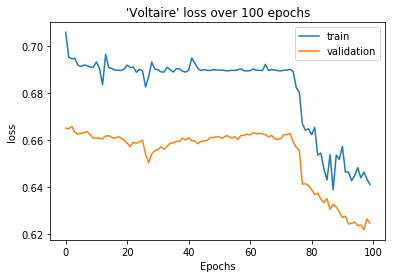

Average Training Score: 0.6814005192634144
Average Validation Score: 0.6537632084720664


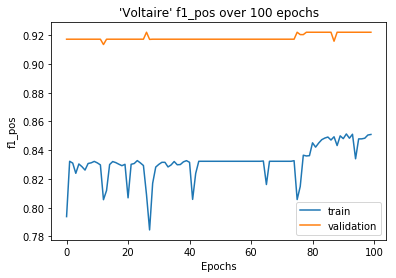

Average Training Score: 0.8318431697285763
Average Validation Score: 0.9184189769206186


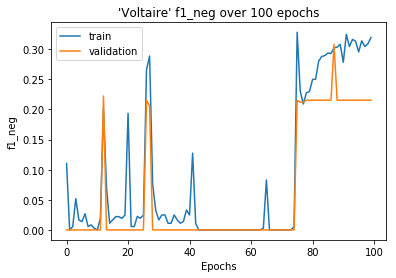

Average Training Score: 0.09186588266619955
Average Validation Score: 0.06113885460944285
Wrote metrics to 'raw_logs/Voltaire.csv'

validating on book: 'Browne'
Creating JQ's net1.
train counts {0: 601, 1: 1857}

Epoch 0/99
----------
Phase:train
average loss: 0.7003679783049398
f1_pos: 0.8193008370260957
f1_neg: 0.1405152224824356

Phase:val
average loss: 0.7468997471862369
f1_pos: 0.7142857142857143
f1_neg: 0


Epoch 1/99
----------
Phase:train
average loss: 0.69179895464437
f1_pos: 0.859465737514518
f1_neg: 0.009819967266775777

Phase:val
average loss: 0.7416418376896117
f1_pos: 0.7142857142857143
f1_neg: 0


Epoch 2/99
----------
Phase:train
average loss: 0.6889719248690966
f1_pos: 0.8597957288765087
f1_neg: 0.006578947368421053

Phase:val
average loss: 0.7389244321319792
f1_pos: 0.7142857142857143
f1_neg: 0


Epoch 3/99
----------
Phase:train
average loss: 0.6881535881607391
f1_pos: 0.8574755472752679
f1_neg: 0.01607717041800643

Phase:val
average loss: 0.7343373944362005
f1_pos: 

Phase:train
average loss: 0.6631744358236951
f1_pos: 0.8565863160457755
f1_neg: 0.2719406674907293

Phase:val
average loss: 0.747648310330179
f1_pos: 0.7088607594936709
f1_neg: 0.03592814371257485


Epoch 42/99
----------
Phase:train
average loss: 0.6649109238623797
f1_pos: 0.860408560311284
f1_neg: 0.28606965174129356

Phase:val
average loss: 0.7500101841158338
f1_pos: 0.7088607594936709
f1_neg: 0.03592814371257485


Epoch 43/99
----------
Phase:train
average loss: 0.6516418075833115
f1_pos: 0.8712249335588307
f1_neg: 0.31402831402831405

Phase:val
average loss: 0.7507296005884806
f1_pos: 0.7101449275362319
f1_neg: 0.047619047619047616


Epoch 44/99
----------
Phase:train
average loss: 0.6490087750192771
f1_pos: 0.866232827187274
f1_neg: 0.27640156453715775

Phase:val
average loss: 0.7516867253515456
f1_pos: 0.7127272727272728
f1_neg: 0.07058823529411765


Epoch 45/99
----------
Phase:train
average loss: 0.6418912598667734
f1_pos: 0.8706455542021925
f1_neg: 0.345252774352651

Phase:va

Phase:train
average loss: 0.6196949959674243
f1_pos: 0.8665
f1_neg: 0.4170305676855895

Phase:val
average loss: 0.807467112938563
f1_pos: 0.7153284671532847
f1_neg: 0.09302325581395349


Epoch 79/99
----------
Phase:train
average loss: 0.6061104511564781
f1_pos: 0.872063968015992
f1_neg: 0.43982494529540483

Phase:val
average loss: 0.8087643567058775
f1_pos: 0.7153284671532847
f1_neg: 0.09302325581395349


Epoch 80/99
----------
Phase:train
average loss: 0.6261103279688573
f1_pos: 0.8699775393062141
f1_neg: 0.42684268426842686

Phase:val
average loss: 0.8105579912662506
f1_pos: 0.7140255009107468
f1_neg: 0.08187134502923978


Epoch 81/99
----------
Phase:train
average loss: 0.624080051715729
f1_pos: 0.86921929388364
f1_neg: 0.41163310961968685

Phase:val
average loss: 0.8087208949857287
f1_pos: 0.7153284671532847
f1_neg: 0.09302325581395349


Epoch 82/99
----------
Phase:train
average loss: 0.6205192799244207
f1_pos: 0.8761149653121902
f1_neg: 0.4318181818181818

Phase:val
average loss

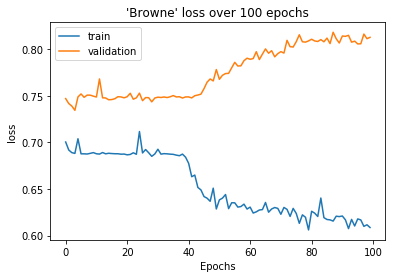

Average Training Score: 0.6527850170593567
Average Validation Score: 0.775031015889512


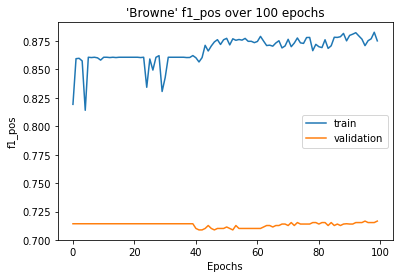

Average Training Score: 0.8667930513562884
Average Validation Score: 0.7133445548504196


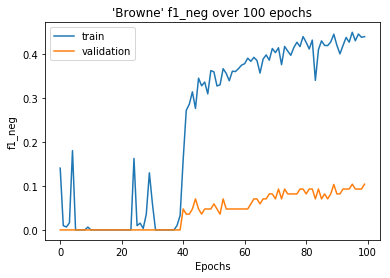

Average Training Score: 0.23808498198283232
Average Validation Score: 0.04233411552584951
Wrote metrics to 'raw_logs/Browne.csv'

validating on book: 'Allestree'
Creating JQ's net1.
train counts {0: 695, 1: 1845}

Epoch 0/99
----------
Phase:train
average loss: 0.7121664803093812
f1_pos: 0.5766129032258064
f1_neg: 0.40114068441064643

Phase:val
average loss: 0.700995227844595
f1_pos: 0
f1_neg: 0.3837209302325581


Epoch 1/99
----------
Phase:train
average loss: 0.7090423117472431
f1_pos: 0.41174284652545523
f1_neg: 0.33737965676015064

Phase:val
average loss: 0.7000095141019752
f1_pos: 0
f1_neg: 0.3837209302325581


Epoch 2/99
----------
Phase:train
average loss: 0.7026839248777375
f1_pos: 0.14008518693800287
f1_neg: 0.38759689922480617

Phase:val
average loss: 0.6981797428439847
f1_pos: 0
f1_neg: 0.3837209302325581


Epoch 3/99
----------
Phase:train
average loss: 0.7000406242261722
f1_pos: 0.28728813559322036
f1_neg: 0.3816176470588235

Phase:val
average loss: 0.6951776228362708
f1_p

Phase:val
average loss: 0.6344764742919867
f1_pos: 0.8719008264462811
f1_neg: 0.1388888888888889


Epoch 38/99
----------
Phase:train
average loss: 0.668586820692528
f1_pos: 0.8518344308560678
f1_neg: 0.23913043478260873

Phase:val
average loss: 0.5408947609311385
f1_pos: 0.9739952718676123
f1_neg: 0.9172932330827067


Epoch 39/99
----------
Phase:train
average loss: 0.6685115918869109
f1_pos: 0.8506293042032771
f1_neg: 0.2761795166858458

Phase:val
average loss: 0.5064862925800488
f1_pos: 0.9739952718676123
f1_neg: 0.9172932330827067


Epoch 40/99
----------
Phase:train
average loss: 0.6701252626621818
f1_pos: 0.8335352556336323
f1_neg: 0.27911857292759706

Phase:val
average loss: 0.4670743365510762
f1_pos: 0.9739952718676123
f1_neg: 0.9172932330827067


Epoch 41/99
----------
Phase:train
average loss: 0.6596028926569646
f1_pos: 0.8418024928092042
f1_neg: 0.27312775330396477

Phase:val
average loss: 0.45797484577130926
f1_pos: 0.9764150943396226
f1_neg: 0.9242424242424242


Epoch 42/9

Phase:val
average loss: 0.39639107614970037
f1_pos: 0.9764150943396226
f1_neg: 0.9242424242424242


Epoch 75/99
----------
Phase:train
average loss: 0.663854413708364
f1_pos: 0.8476121910247181
f1_neg: 0.3044906900328587

Phase:val
average loss: 0.4342846304392643
f1_pos: 0.9764150943396226
f1_neg: 0.9242424242424242


Epoch 76/99
----------
Phase:train
average loss: 0.6504101021317985
f1_pos: 0.8487191880135332
f1_neg: 0.33545647558386416

Phase:val
average loss: 0.4023245519442524
f1_pos: 0.9739952718676123
f1_neg: 0.9172932330827067


Epoch 77/99
----------
Phase:train
average loss: 0.6616751227087861
f1_pos: 0.8354120811934458
f1_neg: 0.32088799192734613

Phase:val
average loss: 0.40025868432984935
f1_pos: 0.9764150943396226
f1_neg: 0.9242424242424242


Epoch 78/99
----------
Phase:train
average loss: 0.6648910985922251
f1_pos: 0.8462090408993064
f1_neg: 0.28476084538375973

Phase:val
average loss: 0.44202816979490595
f1_pos: 0.9788235294117646
f1_neg: 0.9312977099236641


Epoch 79

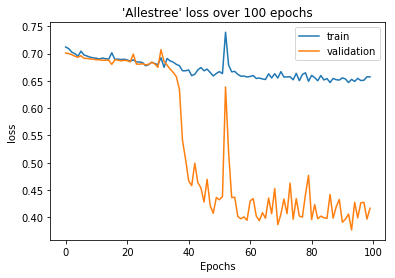

Average Training Score: 0.6716307458863484
Average Validation Score: 0.5266248213280019


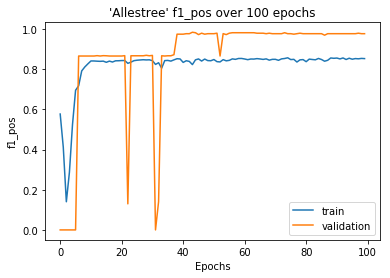

Average Training Score: 0.818093855393201
Average Validation Score: 0.8586987097762641


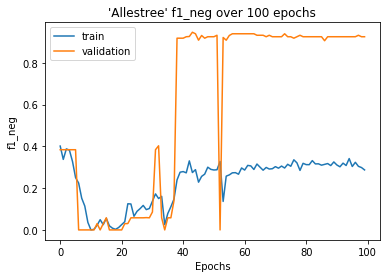

Average Training Score: 0.2296139417625324
Average Validation Score: 0.6058597725551345
Wrote metrics to 'raw_logs/Allestree.csv'

validating on book: 'Ascham'
Creating JQ's net1.
train counts {0: 741, 1: 1981}

Epoch 0/99
----------
Phase:train
average loss: 0.7052775691923721
f1_pos: 0.5949820788530467
f1_neg: 0.3530534351145038

Phase:val
average loss: 0.701279204338789
f1_pos: 0
f1_neg: 0.3448275862068966


Epoch 1/99
----------
Phase:train
average loss: 0.7016987887749683
f1_pos: 0.40270366417644965
f1_neg: 0.36232434485377896

Phase:val
average loss: 0.6952199563384056
f1_pos: 0
f1_neg: 0.3448275862068966


Epoch 2/99
----------
Phase:train
average loss: 0.7004131229155034
f1_pos: 0.544230180593817
f1_neg: 0.31603123564538355

Phase:val
average loss: 0.6887929824491342
f1_pos: 0.6434782608695652
f1_neg: 0.4675324675324675


Epoch 3/99
----------
Phase:train
average loss: 0.693866914243579
f1_pos: 0.660387811634349
f1_neg: 0.33151581243184297

Phase:val
average loss: 0.69338210175

Phase:val
average loss: 0.42835513936976594
f1_pos: 0.9599999999999999
f1_neg: 0.8571428571428572


Epoch 37/99
----------
Phase:train
average loss: 0.6456863715051291
f1_pos: 0.8592820964545254
f1_neg: 0.29235880398671094

Phase:val
average loss: 0.4275075575957696
f1_pos: 0.9599999999999999
f1_neg: 0.8571428571428572


Epoch 38/99
----------
Phase:train
average loss: 0.6491299558220148
f1_pos: 0.8583388411544393
f1_neg: 0.28950276243093925

Phase:val
average loss: 0.4265160585443179
f1_pos: 0.9599999999999999
f1_neg: 0.8571428571428572


Epoch 39/99
----------
Phase:train
average loss: 0.6423745367082053
f1_pos: 0.859412933127345
f1_neg: 0.3023001095290252

Phase:val
average loss: 0.4282824161152045
f1_pos: 0.9599999999999999
f1_neg: 0.8571428571428572


Epoch 40/99
----------
Phase:train
average loss: 0.648194850826859
f1_pos: 0.8563192904656319
f1_neg: 0.30620985010706636

Phase:val
average loss: 0.43647117416063946
f1_pos: 0.9599999999999999
f1_neg: 0.8571428571428572


Epoch 41/9

Phase:val
average loss: 0.5773711657772461
f1_pos: 0.29213483146067415
f1_neg: 0.38834951456310685


Epoch 74/99
----------
Phase:train
average loss: 0.6399875502652933
f1_pos: 0.8533513270355376
f1_neg: 0.34669338677354716

Phase:val
average loss: 0.4220958383133014
f1_pos: 0.9219858156028369
f1_neg: 0.7843137254901961


Epoch 75/99
----------
Phase:train
average loss: 0.6320836198715319
f1_pos: 0.8487337440109515
f1_neg: 0.3751178133836004

Phase:val
average loss: 0.6527637268106142
f1_pos: 0.2117647058823529
f1_neg: 0.37383177570093457


Epoch 76/99
----------
Phase:train
average loss: 0.6382770113302101
f1_pos: 0.8500226551880381
f1_neg: 0.3572815533980583

Phase:val
average loss: 1.1696118066708248
f1_pos: 0.05128205128205127
f1_neg: 0.3508771929824561


Epoch 77/99
----------
Phase:train
average loss: 0.6397665720008735
f1_pos: 0.8569503705367167
f1_neg: 0.3572149344096872

Phase:val
average loss: 0.7176307154198488
f1_pos: 0.1904761904761905
f1_neg: 0.37037037037037035


Epoch 7

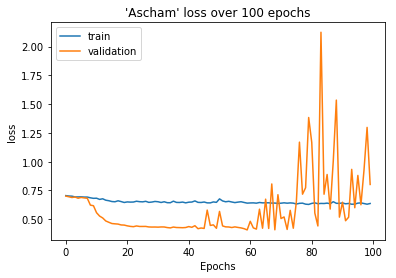

Average Training Score: 0.6510854742460879
Average Validation Score: 0.5889311733096838


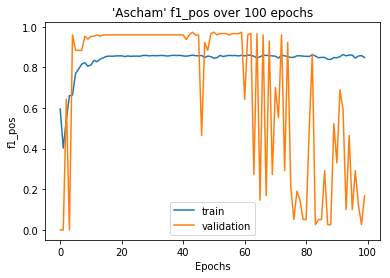

Average Training Score: 0.8371802823732319
Average Validation Score: 0.6923316282461538


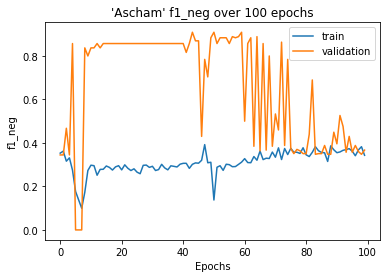

Average Training Score: 0.3105456187276593
Average Validation Score: 0.6567195275102496
Wrote metrics to 'raw_logs/Ascham.csv'

training complete


In [12]:
# ========================================
# Step 5. execute the train process
# ========================================

# overriding to use CPU when GPU is busy
use_gpu = True
print('use_gpu is ' + str(use_gpu))


phases = ['train', 'val']
metric_types = ['loss', 'tn', 'fp', 'fn', 'tp', 'f1_pos', 'f1_neg']
metric_types_plot = ['loss', 'f1_pos', 'f1_neg']
metric_names_all = [p+'-'+m for p in phases for m in metric_types]
metric_names_plot = [p+'-'+m for p in phases for m in metric_types_plot]

all_metrics = {book : {metric : [] for metric in metric_names_all} for book in books_in_data}

# train parameters
# num_training_epochs = 5
num_training_epochs = 100

# leave-one-book-out cross validation
for val_book in books_in_data:
    print("validating on book: '" + str(val_book) + "'")
    
    # define the train and validation loaders
    train_books = books_in_data - set([val_book])
    cross_val_loaders = {}
    cross_val_loaders["train"] = {b : book_data_loaders[b]["train"] for b in train_books}
    cross_val_loaders["val"] = {b : book_data_loaders[b]["val"] for b in [val_book]}
    
    # get the model architecture
    model = create_model_architecture('jq_net1')
    
    # model hyperparameters
    # check weights added to CrossEntropyLoss [1, 1/(#pos in train / #neg in train)]
    train_counts = {c : sum([image_counts[b][c] for b in train_books]) for c in [0,1]}
    print('train counts', train_counts)
    loss_weights = torch.FloatTensor([1, float(train_counts[0])/float(train_counts[1])])
    if use_gpu:
        loss_weights = loss_weights.cuda()
    else:
        loss_weights = loss_weights.cpu()
    criterion = nn.CrossEntropyLoss(weight = loss_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # train
    trained_model, train_metrics = train(model,
                                         criterion,
                                         optimizer,
                                         cross_val_loaders,
                                         num_epochs=num_training_epochs)
    
    # update metrics dicts
    all_metrics[str(val_book)] = train_metrics
    
    # plot all metrics
    for metric in metric_types_plot:
        plot_values(all_metrics[str(val_book)]['train-' + str(metric)],
                   all_metrics[str(val_book)]['val-' + str(metric)],
                   "'" + str(val_book) + "' " + str(metric) + " over " + str(num_training_epochs) + " epochs",
                   ylabel = str(metric))
        
    # write metrics to file
    write_metrics_to_csv(all_metrics[str(val_book)], metric_names_all, 'raw_logs', str(val_book) + '.csv')
    
    print()
    
    # remove the break as needed
#     break


print("training complete")

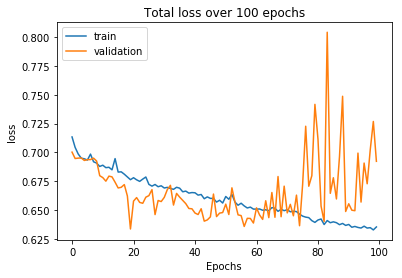

Average Training Score: 0.6611265678682227
Average Validation Score: 0.6675185467954176


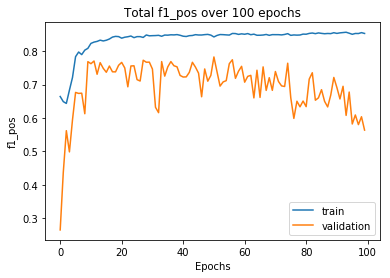

Average Training Score: 0.8359238770483169
Average Validation Score: 0.6950055908750836


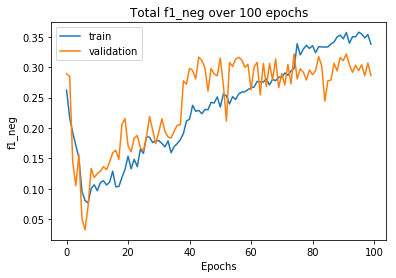

Average Training Score: 0.2357257701277849
Average Validation Score: 0.24466052267378757


In [13]:
# compute and plot total loss
# total_train_loss = [sum([all_train_loss[b][i] for b in all_train_loss]) for i in range(num_training_epochs)]
# total_val_loss = [sum([all_val_loss[b][i] for b in all_val_loss]) for i in range(num_training_epochs)]
# plot_losses(total_train_loss, total_val_loss, "Total losses over " + str(num_training_epochs) + " epochs")

total_metrics = {metric : [np.mean([all_metrics[book][metric][epoch] for book in all_metrics])
                           for epoch in range(num_training_epochs)]
                 for metric in metric_names_plot}

for metric in metric_types_plot:
    plot_values(total_metrics['train-' + str(metric)],
                   total_metrics['val-' + str(metric)],
                   "Total " + str(metric) + " over " + str(num_training_epochs) + " epochs",
                   ylabel = str(metric))
